# Creating postage stamp cutouts for alerts

In [1]:
#!pip install wcsaxes # for plotting with wcs

In [2]:
from __future__ import print_function, division

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

## Input data from Twinkles

Read in Twinkles simulated file.  See afw help from https://github.com/DarkEnergyScienceCollaboration/DataManagementWorkbook.

In [3]:
twinklesfile = '/Users/maria/Desktop/dm-alert/twinkles1/calexp/v840-fr/R22/S11.fits'
exposure = afwImage.ExposureF(twinklesfile)
maskedImage = exposure.getMaskedImage()  #maskedImageF

# These three are held in the maskedImage
image       = maskedImage.getImage()  #lsst.afw.image.imageLib.ImageF
mask        = maskedImage.getMask()  #lsst.afw.image.imageLib.MaskU
variance    = maskedImage.getVariance() #lsst.afw.image.imageLib.ImageF

# These things are in the exposure
wcs         = exposure.getWcs() #lsst.afw.image.imageLib.Wcs
metadata    = exposure.getMetadata() #lsst.daf.base.baseLib.PropertySet
psf         = exposure.getPsf() #lsst.afw.detection.detectionLib.Psf

Stats and viz on the full exposure

In [4]:
statFlags = afwMath.NPOINT | afwMath.MEAN | afwMath.STDEV | afwMath.MAX | afwMath.MIN | afwMath.ERRORS
print ("The statistics flags are set to %s."%bin(statFlags))

The statistics flags are set to 0b110000001111.


In [5]:
control = afwMath.StatisticsControl()
SAT = afwImage.MaskU_getPlaneBitMask("SAT")
control.setAndMask(SAT);        #pixels with this mask bit set will be ignored.


imageStatistics = afwMath.makeStatistics(maskedImage, statFlags, control)
numBins         = imageStatistics.getResult(afwMath.NPOINT)[0]
immean          = imageStatistics.getResult(afwMath.MEAN)[0]
imstdev         = imageStatistics.getResult(afwMath.STDEV)[0]

print ("The image has dimensions %i x %i pixels" %(maskedImage.getWidth(), maskedImage.getHeight()) )
print ("Number of analyzed bins in image is %i"  %numBins )
print ("Max    = %9d"                            %imageStatistics.getResult(afwMath.MAX)[0] )
print ("Min    = %9d"                            %imageStatistics.getResult(afwMath.MIN)[0] )
print ("Mean   = %9.8f +- %3.1f"                 %imageStatistics.getResult(afwMath.MEAN) )
print ("StdDev = %9.2f"                          %imageStatistics.getResult(afwMath.STDEV)[0] )

The image has dimensions 4000 x 4072 pixels
Number of analyzed bins in image is 16287572
Max    =     99314
Min    =      -267
Mean   = 6.61451286 +- 0.1
StdDev =    363.26


Plot original data.

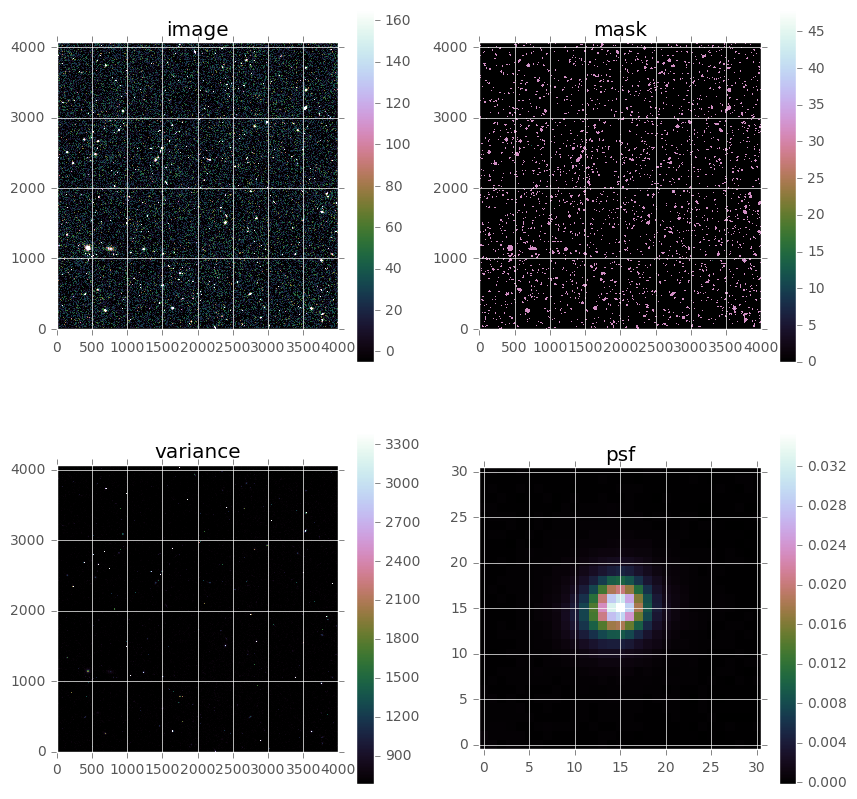

In [6]:
settings = dict(cmap='cubehelix', interpolation='nearest', origin='lower')

plt.figure()
plt.figure(figsize=(10,10))

# image
plt.subplot(221)
plt.title('image')
plt.imshow(image.getArray(), vmin=-5, vmax=25*immean, **settings)
plt.colorbar()

# mask
plt.subplot(222)
plt.title('mask')
plt.imshow(mask.getArray(), **settings)
plt.colorbar()

# variance
plt.subplot(223)
plt.title('variance')
plt.imshow(variance.getArray(), vmin=np.mean(variance.getArray()), vmax=5*np.mean(variance.getArray()), **settings)
plt.colorbar()
      
# psf
plt.subplot(224)
plt.title('psf')
plt.imshow(psf.computeImage().getArray(), **settings)
plt.colorbar()

### Footprints
Make footprints from the Twinkles file.

In [7]:
import lsst.afw.detection as afwDet


thresholdValue = 500
npixMin        = 5 
grow           = 1
isotropic      = False

threshold = afwDet.Threshold(thresholdValue, afwDet.Threshold.VALUE)
footPrintSet  = afwDet.FootprintSet(maskedImage, threshold, "DETECTED", npixMin)
footPrintSet  = afwDet.FootprintSet(footPrintSet, grow, isotropic)

footPrints = footPrintSet.getFootprints()

footPrintSet.setMask(maskedImage.getMask(), "DETECTED")

print( "I found ", footPrints.size(), "footPrint(s)\n")

for i in range(0,footPrints.size()):
    print ("\nFootprint:",i)
    
    peak = footPrints[i].getPeaks()[0]
    print ("A peak of value", peak.getPeakValue())
    print ("was found at X =", peak.getFx(),"Y =",peak.getFy())

I found  248 footPrint(s)


Footprint: 0
A peak of value 2142.49731445
was found at X = 2248.0 Y = 8.0

Footprint: 1
A peak of value 717.187072754
was found at X = 55.0 Y = 39.0

Footprint: 2
A peak of value 1958.6003418
was found at X = 2526.0 Y = 60.0

Footprint: 3
A peak of value 730.448974609
was found at X = 2625.0 Y = 69.0

Footprint: 4
A peak of value 1166.44604492
was found at X = 500.0 Y = 79.0

Footprint: 5
A peak of value 669.35760498
was found at X = 3769.0 Y = 125.0

Footprint: 6
A peak of value 68751.5234375
was found at X = 2889.0 Y = 162.0

Footprint: 7
A peak of value 888.419311523
was found at X = 2340.0 Y = 183.0

Footprint: 8
A peak of value 1172.99963379
was found at X = 3106.0 Y = 190.0

Footprint: 9
A peak of value 2061.80395508
was found at X = 3435.0 Y = 205.0

Footprint: 10
A peak of value 1721.7088623
was found at X = 3761.0 Y = 210.0

Footprint: 11
A peak of value 1597.8125
was found at X = 686.0 Y = 263.0

Footprint: 12
A peak of value 636.264343262
was fou

### Making a postage stamp
Make multi-extension fits files with info required from the DPDD.

In [8]:
from astropy.io import fits


def makeStamp(fitsfile, fp):
    bb = fp.getBBox()
    print('initial fp area (pixels):', bb.getArea())
    print('initial width:', bb.getWidth())
    print('initial height', bb.getHeight())

    # DPDD says no smaller than 30x30
    minside = 30
    while bb.getWidth() < minside:
        bb.grow(afwGeom.Extent2I(1, 0))
    while bb.getHeight() < minside:
        bb.grow(afwGeom.Extent2I(0, 1))

    print('new width:', bb.getWidth())
    print('new height', bb.getHeight())
    print('stamp area (pixels):', bb.getArea())

    cutout = afwImage.ExposureF(fitsfile, bb) #lsst.afw.image.imageLib.ExposureF
    cutout_image = cutout.getMaskedImage().getImage() #lsst.afw.image.imageLib.ImageF
    cutout_mask = cutout.getMaskedImage().getMask() #lsst.afw.image.imageLib.MaskU
    cutout_variance = cutout.getMaskedImage().getVariance() #lsst.afw.image.imageLib.ImageF
    
    cutout_psf = cutout.getPsf() #lsst.afw.detection.detectionLib.Psf
    cutout_calib = cutout.getCalib() #lsst.afw.image.imageLib.Calib
    cutout_wcs = cutout.getWcs() #lsst.afw.image.imageLib.Wcs
    cutout_filter = cutout.getFilter() #lsst.afw.image.imageLib.Filter
    
    # need to update wcs for the bbox and generate header from updated wcs
    # https://lsst-web.ncsa.illinois.edu/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_exposure_info.html#l00186
    new_wcs = cutout_wcs
    new_wcs.shiftReferencePixel(-cutout.getXY0().getX(), -cutout.getXY0().getY()) 
    new_wcs_meta = new_wcs.getFitsMetadata()

    header = {name:new_wcs_meta.toDict()[name]
          for name in new_wcs_meta.toDict().keys()
          if not name.startswith(("A","B"))} # drop higher order terms

    # add reference info for original exposure
    # https://lsst-web.ncsa.illinois.edu/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_exposure_info.html#a04e0cc09291e5f3916daf556553aafdd
    header['LTV1'] = -cutout.getXY0().getX()
    header['LTV2'] = -cutout.getXY0().getY()
    header['CRVAL1A'] = cutout.getXY0().getX()
    header['CRVAL2A'] = cutout.getXY0().getY()
    # other fields that are included when writing out exposure subsets
    header['CRPIX1A'] = 1
    header['CRPIX2A'] = 1
    header['CTYPE1A'] = 'LINEAR' 
    header['CTYPE2A'] = 'LINEAR' 
    header['CUNIT1A'] = 'PIXEL' 
    header['CUNIT2A'] = 'PIXEL' 
    # DPDD says need zero point
    header['FLUXMAG0'], header['HIERARCH FLUXMAG0ERR'] = cutout_calib.getFluxMag0()
    # also add filter name
    header['FILTER'] = cutout_filter.getName()
    
    im = fits.PrimaryHDU(cutout_image.getArray())
    mask = fits.ImageHDU(cutout_mask.getArray())
    var = fits.ImageHDU(cutout_variance.getArray())
    psf = fits.ImageHDU(cutout_psf.computeImage().getArray())

    # header for each hdu
    for name, val in sorted(header.items()):
        im.header[name] = val
        mask.header[name] = val
        var.header[name] = val

    im.header['EXTTYPE'] = 'IMAGE'
    im.header['EXTNAME'] = 'IMAGE'
    mask.header['EXTTYPE'] = 'MASK' 
    mask.header['EXTNAME'] = 'MASK' 
    var.header['EXTTYPE'] = 'VARIANCE'
    var.header['EXTNAME'] = 'VARIANCE'    
    psf.header['EXTTYPE'] = 'PSF'
    psf.header['EXTNAME'] = 'PSF'

    return fits.HDUList([im, mask, var, psf])


In [9]:
# Make a few postage stamps in multi-extension fits format.
# Get them away from the edge to avoid boundary problem when growing bbox
for fp in footPrints[len(footPrints)//2:len(footPrints)//2+4]:
    fpid = fp.getId()
    print('\nfootprint id:', fpid)
    stamp = makeStamp(twinklesfile, fp)
    stamp_file = 'stamp-'+str(fpid)+'.fits'
    stamp.writeto(stamp_file, clobber=True)


footprint id: 676
initial fp area (pixels): 49
initial width: 7
initial height 7
new width: 31
new height 31
stamp area (pixels): 961

footprint id: 677
initial fp area (pixels): 462
initial width: 22
initial height 21
new width: 30
new height 31
stamp area (pixels): 930

footprint id: 678
initial fp area (pixels): 576
initial width: 24
initial height 24
new width: 30
new height 30
stamp area (pixels): 900

footprint id: 679
initial fp area (pixels): 100
initial width: 10
initial height 10
new width: 30
new height 30
stamp area (pixels): 900


### Check stamp output file makes sense
Make plots for one stamp.

Filename: stamp-679.fits
No.    Name         Type      Cards   Dimensions   Format
0    IMAGE       PrimaryHDU      35   (30, 30)     float32   
1    MASK        ImageHDU        38   (30, 30)     int16 (rescales to uint16)   
2    VARIANCE    ImageHDU        36   (30, 30)     float32   
3    PSF         ImageHDU         9   (31, 31)     float64   


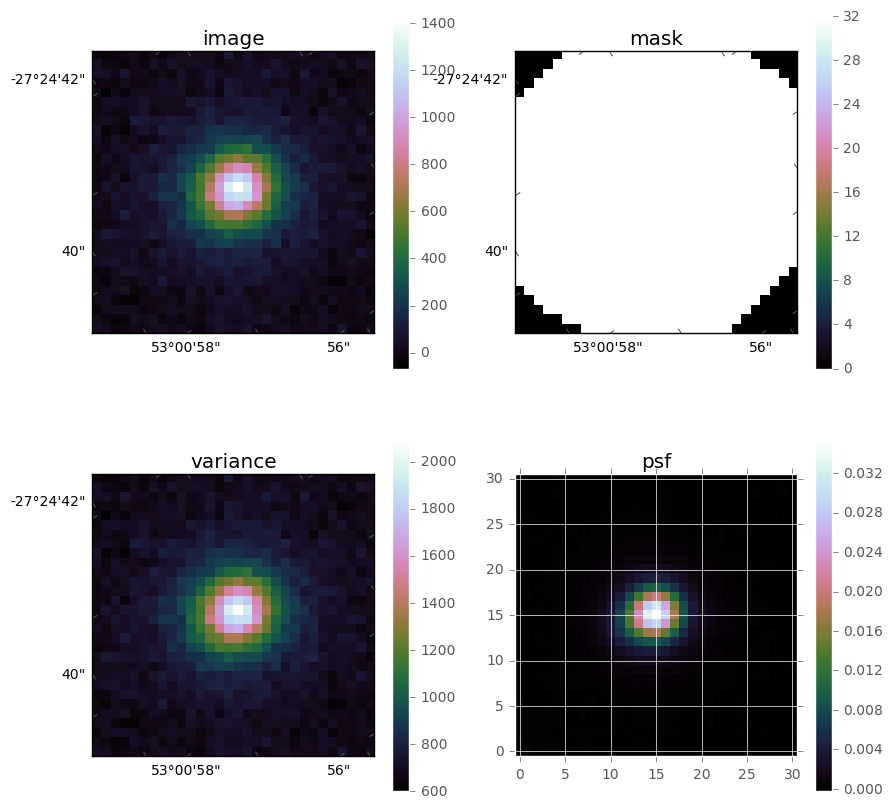

In [10]:
from astropy.wcs import WCS


fits.info(stamp_file)

with fits.open(stamp_file) as hdu:
    im_wcs = WCS(hdu[0].header)
    mask_wcs = WCS(hdu[1].header)
    var_wcs = WCS(hdu[2].header)
    
image_data = fits.getdata(stamp_file, ext=0)
mask_data = fits.getdata(stamp_file, ext=1)
var_data = fits.getdata(stamp_file, ext=2)
psf_data = fits.getdata(stamp_file, ext=3)

fig = plt.figure(figsize=(10,10))

# image
fig.add_subplot(221, projection=im_wcs)
plt.title('image')
plt.imshow(image_data, **settings)
plt.colorbar()

# mask
fig.add_subplot(222, projection=mask_wcs)
plt.title('mask')
plt.imshow(mask_data, **settings)
plt.colorbar()

# variance
fig.add_subplot(223, projection=var_wcs)
plt.title('variance')
plt.imshow(var_data, **settings)
plt.colorbar()

# psf
plt.subplot(224)
plt.title('psf')
plt.imshow(psf_data, **settings)
plt.colorbar()

Look at headers.

In [11]:
print('image header:')
print(repr(fits.getheader(stamp_file,0)))
print('\nmask header:')
print(repr(fits.getheader(stamp_file,1)))
print('\nvariance header:')
print(repr(fits.getheader(stamp_file,2)))
print('\npsf header:')
print(repr(fits.getheader(stamp_file,3)))

image header:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   30                                                  
NAXIS2  =                   30                                                  
EXTEND  =                    T                                                  
CD1_1   = -3.0298457783144E-05                                                  
CD1_2   = 4.65770542146534E-05                                                  
CD2_1   = -4.6588044497537E-05                                                  
CD2_2   = -3.0306475118993E-05                                                  
CRPIX1  =    573.7220720569026                                                  
CRPIX1A =                    1                                                  
CRPIX2  =    1